# 1. Setup

1.1 Install Dependencies

In [2]:
# !pip install tensorflow==2.16.2  opencv-python matplotlib

1.2 Import Dependencies


In [3]:
#Import Standard dependenccies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import TensorFlow dependencies - Functional API
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Input, Flatten, Layer
import tensorflow as tf

1.3 Set GPU Growth


In [5]:
# Avoid OOM errors by setting GPU memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1.4 Create Folder Structures


In [6]:
#setup Paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data', 'negetive')
ANC_PATH = os.path.join('data', "anchor")

In [7]:
# Make the Directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

2.1 Untar Labelled Faces in the Wild Dataset


In [8]:
# http://vis-www.cs.umass.edu/lfw/

In [9]:
#Uncompress Tar GZ labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [10]:
#Move LFW Image to the following Repo data/negetive
for directory in os.listdir('lfw'):
    directory_path = os.path.join('lfw', directory)
    if os.path.isdir(directory_path):  # Check if it's a directory
        for file in os.listdir(directory_path):
            EX_PATH = os.path.join('lfw', directory, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

2.2 Collect Positive and Anchor Classses


In [11]:
# Import uuid lib to generate unique image names
import uuid

In [15]:
'{}.jpg'.format(uuid.uuid1())

'e67bcc0c-458c-11ef-acf3-b48c9da5da23.jpg'

In [16]:
# #Establish a Connection  to the webcam
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
    
#     # Cut down the frame to 250x250px
#     frame = frame[120:120+250,200:200+250,:3]

#     # Collect anchors 
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         # Create the unique file path 
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Write out anchor image
#         cv2.imwrite(imgname, frame)
    
#     # Collect positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         # Create the unique file path 
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Write out positive image
#         cv2.imwrite(imgname, frame)
    
#     # Show image back to screen
#     cv2.imshow('Image Collection', frame)
    
#     # Breaking gracefully
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
# # Release the webcam        
# cap.release()
# # Close the image show frame
# cv2.destroyAllWindows()

# 3. Load and Preprocess Image

3.1 Get Image Directories

In [17]:
anchor = tf.data.Dataset.list_files(rf'{ANC_PATH}\*.jpg').take(300)
positive = tf.data.Dataset.list_files(rf'{POS_PATH}\*.jpg').take(300)
negative = tf.data.Dataset.list_files(rf'{NEG_PATH}\*.jpg').take(300)

In [18]:
rf'{NEG_PATH}\*.jpg'

'data\\negetive\\*.jpg'

In [19]:
dir_test = anchor.as_numpy_iterator()


In [20]:
dir_test.next()

b'data\\anchor\\cc9f4dad-40cb-11ef-8cac-b48c9da5da23.jpg'

3.2 Preprocessing -Scale and Resize

In [21]:
def preprocess(file_path):
    
    # Read Image from file path
    byte_img = tf.io.read_file(file_path)

    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    
    #scale the image between 0 and 1
    img = img / 255.0

    # Return the image
    return img

In [22]:
img = preprocess('data\\anchor\\258b98b5-4099-11ef-95da-b48c9da5da23.jpg')

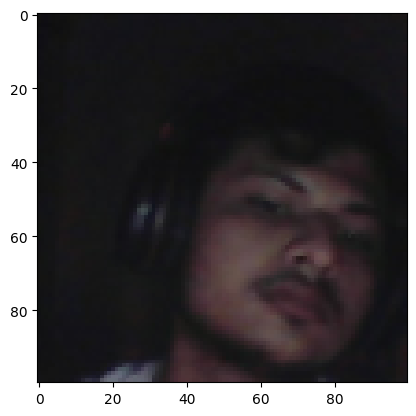

In [23]:
plt.imshow(img)

In [24]:
img.numpy().max()

0.48897058

3.3 Create Labelled Dataset

In [25]:
# (anchor, positive) => 1,1,1,1
# (anchor, negetive) => 0,0,0,0

In [26]:
positive = tf.data.Dataset.zip(anchor ,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
negative = tf.data.Dataset.zip(anchor ,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
data = positive.concatenate(negative)

In [27]:
samples = data.as_numpy_iterator()

In [30]:
example = samples.next()

In [31]:
example

(b'data\\anchor\\9dc0e745-4097-11ef-9eac-b48c9da5da23.jpg',
 b'data\\positive\\a015184a-4097-11ef-a94d-b48c9da5da23.jpg',
 1.0)

3.4 Build Train and Test Partiton

In [32]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [33]:
# Here * -> unpacking the data from example

res = preprocess_twin(*example)

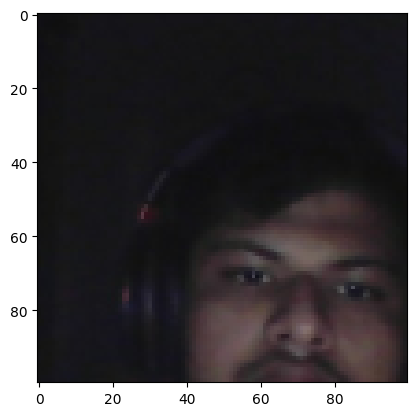

In [34]:
plt.imshow(res[1])

In [35]:
res[2]

1.0

In [36]:
# Build Dataloader pipline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [37]:
samples = data.as_numpy_iterator()

In [38]:
len(samples.next())

3

In [39]:
samp = samples.next()

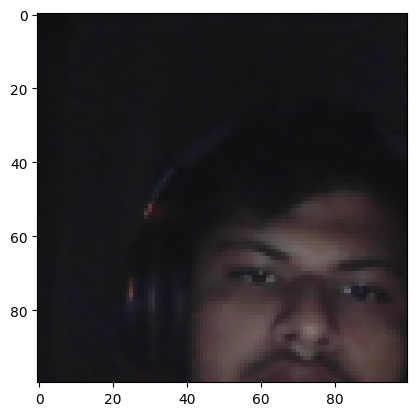

In [40]:
plt.imshow(samp[0])

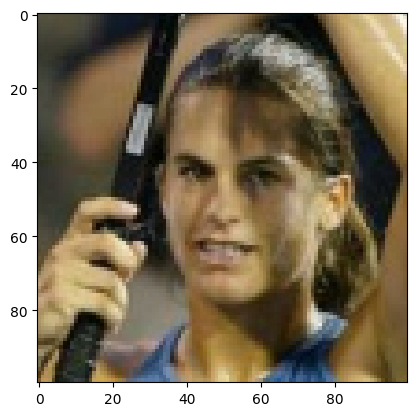

In [41]:
plt.imshow(samp[1])

In [38]:
samp[2]

1.0

In [39]:
round(len(data)*.7)

14

In [40]:
# Training Partition

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [41]:
train_samples = train_data.as_numpy_iterator()

In [42]:
train_samples = train_samples.next()

In [43]:
len(train_samples)

3

In [44]:
len(train_samples[0])

14

In [45]:
# Testing Partition  

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.7))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [46]:
round(len(data)*.7)

14

# 4. Model Engineering 

4.1 Build Embedding Layer

In [47]:
inp = Input(shape=(100,100,3), name='input_image')

In [48]:
inp

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=None, name=input_image>

In [49]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [50]:
c1

<KerasTensor shape=(None, 91, 91, 64), dtype=float32, sparse=False, name=keras_tensor>

In [51]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [52]:
# Second Block 
c2 =  Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [53]:
#Third Block
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [54]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [55]:
# 6*6*256 = f1
f1

<KerasTensor shape=(None, 9216), dtype=float32, sparse=False, name=keras_tensor_7>

In [56]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First Block 
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second Block 
    c2 =  Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)


    #Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)


    # Final Embedding Block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [57]:
embedding = make_embedding()

In [58]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

4.2 Build Distance Layer

In [59]:
# Siamese l1 Distance class -

class L1Dist(Layer):
    # Init Method - inheritance
    def _init_(self, **kwargs):
        super().__init__()
    
    # magic Happens -- similarity calculation
    def call(self, input_embedding,validation_embedding):

        # Ensure the inputs are tensors
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)

        return tf.math.abs(input_embedding - validation_embedding)

In [60]:
l1 = L1Dist()

4.3 Make Siamese Model

In [61]:
input_img = Input(name='input_img', shape=(100,100,3))
Validation_img = Input(name='validation_img', shape=(100,100,3))

In [62]:
inp_embedding = embedding(input_img)
val_embedding = embedding(Validation_img)

In [63]:
inp_embedding

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_18>]

In [64]:
# Example usage
siamese_layer = L1Dist()
distance = siamese_layer(inp_embedding, val_embedding)


In [65]:
classifier = Dense(1, activation='sigmoid')(distance)


In [66]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [67]:
val_embedding

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_19>]

In [68]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [69]:
siamese_model = make_siamese_model()

In [70]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

5.1 Setup Loss and Optimizer

In [71]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [72]:
#optimizer --
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

5.2 Establish Checkpoints

In [73]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

5.3 Build Train Step Function

In [74]:
test_batch = train_data.as_numpy_iterator()

In [75]:
batch_1 = test_batch.next()

In [76]:
len(batch_1[0])

14

In [77]:
batch_1[2]

array([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

In [78]:
X = batch_1[:2]

In [79]:
np.array(X).shape

(2, 14, 100, 100, 3)

In [80]:
y = batch_1[2]

In [81]:
y

array([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
np.array(y).shape

In [82]:
# tf.losses.BinaryCrossentropy??

In [81]:
@tf.function
def train_step(batch):
    X = batch[0]  # pair of images
    y = batch[1]  # label

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Forward pass
        yhat = siamese_model([X[0], X[1]], training=True)
        yhat = tf.squeeze(yhat, axis=[1])  # Adjust the shape of yhat to match y
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    # Calculate gradients
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))

    return loss

5.4 Build Training Loop

In [82]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

5.5 Train the model

In [83]:
EPOCHS = 50

In [84]:
train(train_data, EPOCHS)


 Epoch 1/50


ValueError: in user code:

    File "C:\Users\arkab\AppData\Local\Temp\ipykernel_10616\275230529.py", line 9, in train_step  *
        yhat = siamese_model([X[0], X[1]], training=True)
    File "C:\Users\arkab\AppData\Roaming\Python\Python312\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\arkab\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\input_spec.py", line 245, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "SiameseNetwork" is incompatible with the layer: expected shape=(None, 100, 100, 3), found shape=(100, 100, 3)


# 6. Evaluate Model

6.1 Import Metrics

In [ ]:
# import metric calculations 
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
#  Make Predictions
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


In [ ]:
y_hat

array([[[0.49169847],
        [0.9004793 ],
        [0.8261713 ],
        [0.8986448 ],
        [0.8667075 ],
        [0.48242065]]], dtype=float32)

In [ ]:
# Post Processing the result 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

6.3 Calcilate Metrics

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.33333334

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.25

6.4 Viz Results

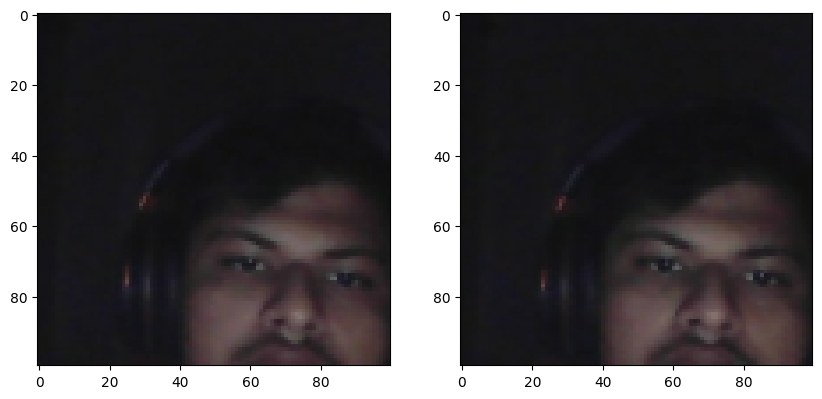

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [1]:
plt.imshow()

NameError: name 'plt' is not defined

In [ ]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [ ]:
L1Dist

__main__.L1Dist

In [ ]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


array([[[0.49169847],
        [0.9004793 ],
        [0.8261713 ],
        [0.8986448 ],
        [0.8667075 ],
        [0.48242065]]], dtype=float32)

In [ ]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real time Test

8.1 Verfication Function

In [ ]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'application_data\\verification_images'

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'application_data\\verification_images'

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

8.2 OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined

In [ ]:
32/50

0.64

In [4]:
echo "Face-Verification-with-a-Siamese-Network" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/darkarka/Face-Verification-with-a-Siamese-Network.git
git push -u origin main

SyntaxError: invalid syntax (2907933001.py, line 1)

In [5]:
git remote add origin https://github.com/darkarka/Face-Verification-with-a-Siamese-Network.git
git branch -M main
git push -u origin main

SyntaxError: invalid syntax (2879992475.py, line 1)